In [2]:
%load_ext autoreload
%autoreload 2
from tf_activation import DeepGraph
from tf_activation.models import mnist_cpcpff as mnist_model

import math
import random

import networkx as nx
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
x = tf.placeholder(tf.float32, [None, 784])

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

# Build the graph for the deep net
net, keep_prob = mnist_model.deepnn(x)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=net['y_conv']))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(net['y_conv'], 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [5]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, '../logdir/models/mnist_cpcpff_2000.0.ckpt')
    print(accuracy.eval(feed_dict={x: mnist.test.images[:1], y_:mnist.test.labels[:1], keep_prob: 1.0}))
    
    batch = mnist.train.next_batch(1)
    
    conv1 = {}
    conv1['W'] = sess.run(net['W_conv1'])
    conv1['i'] = sess.run(net['input'], feed_dict={x: mnist.test.images[:1]})
    conv1['o'] = sess.run(net['h_conv1'], feed_dict={x: mnist.test.images[:1]})
        
    pool1 = {}
    pool1['W'] = conv1['W']
    pool1['i'] = conv1['o']
    pool1['o'] = sess.run(net['h_pool1'], feed_dict={x: mnist.test.images[:1]})
        
    conv2 = {}
    conv2['W'] = sess.run(net['W_conv2'])
    conv2['i'] = pool1['o']
    conv2['o'] = sess.run(net['h_conv2'], feed_dict={x: mnist.test.images[:1]})
        
    pool2 = {}
    pool2['W'] = conv2['W']
    pool2['i'] = conv2['o']
    pool2['o'] = sess.run(net['h_pool2'], feed_dict={x: mnist.test.images[:1]})
        
    fc1 = {}
    fc1['W'] = sess.run(net['W_fc1'])
    fc1['i'] = pool2['o']
    fc1['o'] = sess.run(net['h_fc1'], feed_dict={x: mnist.test.images[:1]})
        
    fc2 = {}
    fc2['W'] = sess.run(net['W_fc2'])
    fc2['i'] = sess.run(net['h_fc1_drop'], feed_dict={x: mnist.test.images[:1], keep_prob: 1.0})
    fc2['o'] = sess.run(net['y_conv'], feed_dict={x: mnist.test.images[:1],  keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ../logdir/models/mnist_cpcpff_2000.0.ckpt
1.0


In [6]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

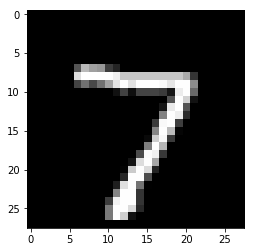

In [7]:
imageToUse = mnist.test.images[0]
plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap="gray")

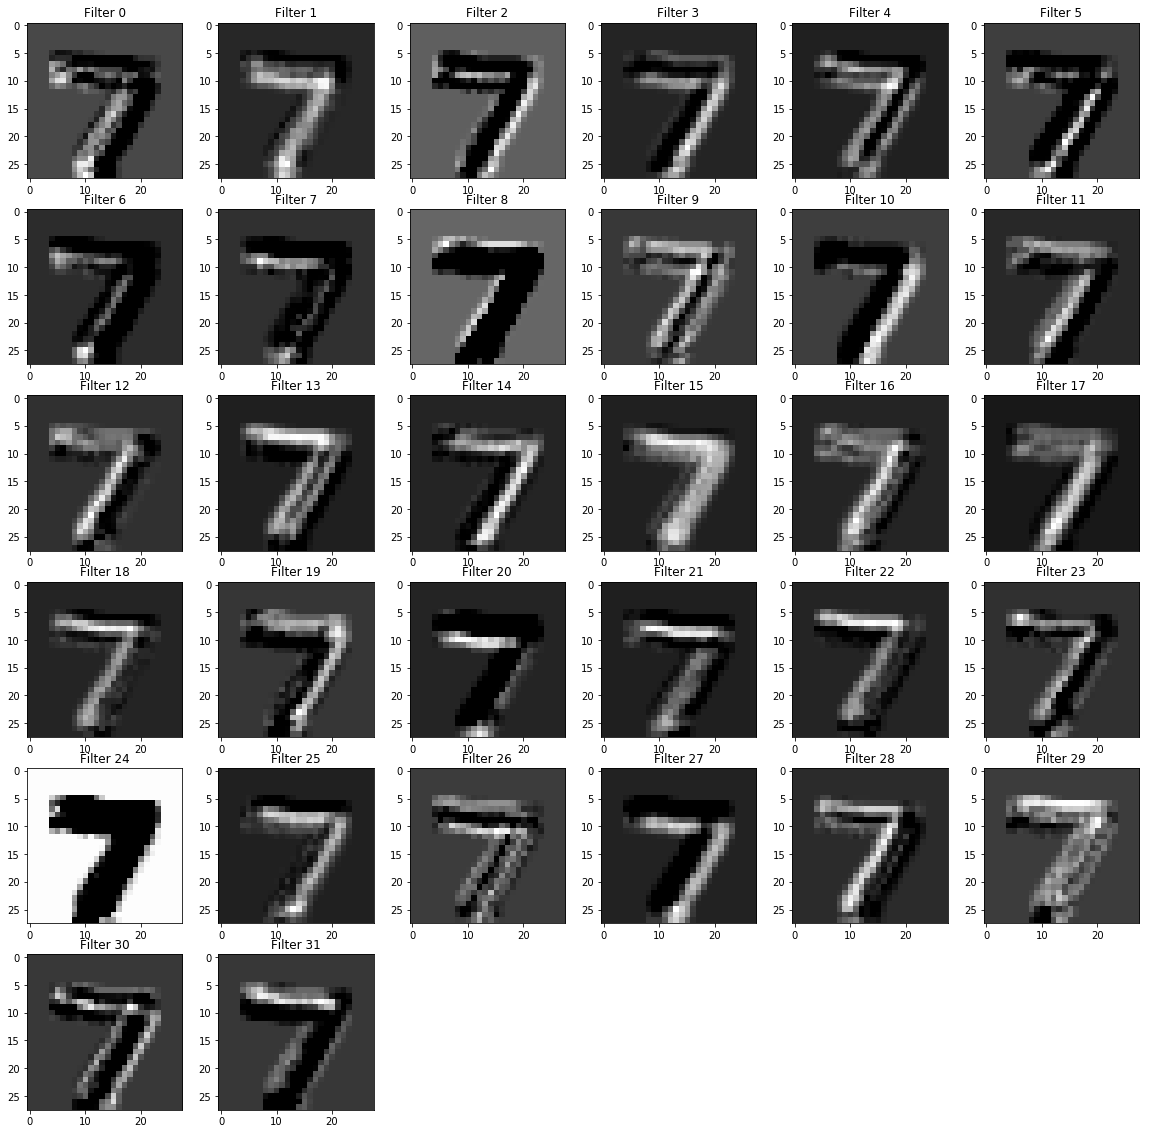

In [8]:
plotNNFilter(conv1['o'])

In [44]:
im = mnist.test.images[0]
lab = mnist.test.labels[61]
print(lab)

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [9]:
seed = 1
random.seed(a=seed)
np.random.seed(seed=seed)
def build_adversaries(im, size=200, num_changes=10, epsilon=.005):
    adversaries = np.empty(shape=(size,im.shape[0],im.shape[1]))
    for i in range(size):
        idxs = np.random.choice(im.shape[1], size=num_changes)
        adversary = np.copy(im[0,:])
        for idx in idxs:
            adversary[idx] = adversary[idx] + random.uniform(-epsilon, epsilon)
        adversaries[i,:,:] = adversary
    return adversaries

In [10]:
def train_adversaries(im, lab, trials=100000, print_every=100, size=200, num_changes=10, epsilon=.005):
    
    ret_adversary = None
    with tf.Session() as sess:
        saver.restore(sess, '../logdir/models/mnist_cpcpff_2000.0.ckpt')
        im = np.reshape(im, (1,im.shape[0]))
        lab = np.reshape(lab, (1, lab.shape[0]))
        print('Initial error: {}'.format(cross_entropy.eval(feed_dict={x: im, y_:lab, keep_prob: 1.0})))

        trial = 0
        trial_im = im
        while trial < trials:
            adversary_set = build_adversaries(trial_im, size=size, num_changes=num_changes, epsilon=epsilon)
            results = np.zeros(shape=(adversary_set.shape[0]))
            for i in range(adversary_set.shape[0]):
                results[i] = cross_entropy.eval(feed_dict={x: adversary_set[i,:, :], y_:lab, keep_prob: 1.0})
            max_idx = np.argmax(results)
            trial_im = adversary_set[max_idx,:,:]
            acc = accuracy.eval(feed_dict={x: trial_im,y_: lab, keep_prob: 1.0})
            if trial % print_every == 0:
                print('Max cross-entropy in trial {}: {}'.format(trial, results[max_idx]))
                print('Accuracy at trial {}: {}'.format(trial,  acc))
            if acc != 1:
                ret_adversary = trial_im
                print('FOUND ADVERSARY AT TRIAL {}'.format(trial))
                print('CLASSIFIED AS: {}'.format(np.argmax(net['y_conv'].eval(feed_dict={x: trial_im,y_: lab, keep_prob: 1.0}))))
                break
            trial = trial + 1
    
    if ret_adversary is None:
        print('DID NOT CONVERGE AFTER {} trials'.format(trial))
    return ret_adversary
            

In [11]:
adversary = train_adversaries(im, lab, epsilon=.005, num_changes=10)

INFO:tensorflow:Restoring parameters from ../logdir/models/mnist_cpcpff_2000.0.ckpt
Initial error: 7.39094866731e-06
Max cross-entropy in trial 0: 7.51015704736e-06
Accuracy at trial 0: 1.0
Max cross-entropy in trial 100: 7.98699056759e-06
Accuracy at trial 100: 1.0
Max cross-entropy in trial 200: 8.58303246787e-06
Accuracy at trial 200: 1.0
Max cross-entropy in trial 300: 9.0598650786e-06
Accuracy at trial 300: 1.0
Max cross-entropy in trial 400: 1.18016496344e-05
Accuracy at trial 400: 1.0
Max cross-entropy in trial 500: 1.68083679455e-05
Accuracy at trial 500: 1.0
Max cross-entropy in trial 600: 2.82522032649e-05
Accuracy at trial 600: 1.0
Max cross-entropy in trial 700: 5.55499864276e-05
Accuracy at trial 700: 1.0
Max cross-entropy in trial 800: 0.000111335277325
Accuracy at trial 800: 1.0
Max cross-entropy in trial 900: 0.000229809098528
Accuracy at trial 900: 1.0
Max cross-entropy in trial 1000: 0.000478391651995
Accuracy at trial 1000: 1.0
Max cross-entropy in trial 1100: 0.0009

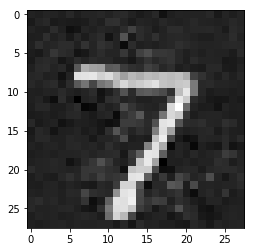

In [12]:
plt.imshow(np.reshape(adversary,[28,28]), interpolation="nearest", cmap="gray")

In [45]:
elite = np.genfromtxt('../logdir/elites/mnist_8_11:11:52_20-07-17.csv', delimiter=',')

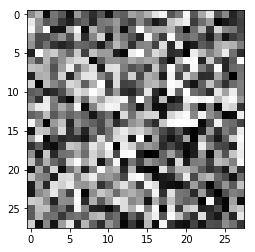

In [46]:
plt.imshow(np.reshape(elite,[28,28]), interpolation="nearest", cmap="gray")

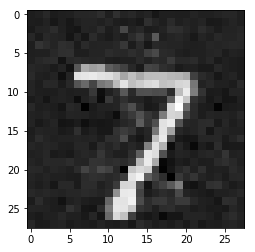

In [49]:
adv = np.genfromtxt('../logdir/adversaries/mnist_7_11:05:48_20-07-17.csv', delimiter=',')
plt.imshow(np.reshape(adv,[28,28]), interpolation="nearest", cmap="gray")